In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import pickle
from functools import reduce
from dateutil.relativedelta import *

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [2]:
from helpers import load, plot, analyse

In [3]:
plot.ERC_Management().set_plot_params()
fig_width = 6.33

In [4]:
## Load data
start_date = '2023-03-04 01:00:00' #gut um nans zu zeigen
end_date = '2023-03-10 02:05:00'
data = load.load_data(start_date, end_date, masked=True, data_type='raw')

In [5]:
misfit_dict_in, medians_in = analyse.get_vault_outliers_median_filter(data, after='_T_in', threshold=0.12)
misfit_dict_out, medians_out = analyse.get_vault_outliers_median_filter(data, after='_T_out', threshold=0.24)
misfit_dict_in, misfit_dict_out

({'Probe_26_T_in': 0.2519444603985987,
  'Probe_29_T_in': 0.48226552179655235,
  'Probe_33_T_in': 0.5180207914536787,
  'Probe_35_T_in': 0.2369326862328348,
  'Probe_13_T_in': 1.6485362701739628},
 {'Probe_13_T_out': 0.33995319051175227})

In [6]:
colors = ['#89CFF0','#A52A2A', '#AFE1AF']

param_csv = pd.read_csv('Supplementary_BHE_Data.csv')
colordict = plot.get_colordict()

(<Figure size 3000x750 with 2 Axes>,
 <Axes: title={'center': 'Data of BHE 13'}, ylabel='T [°C]'>)

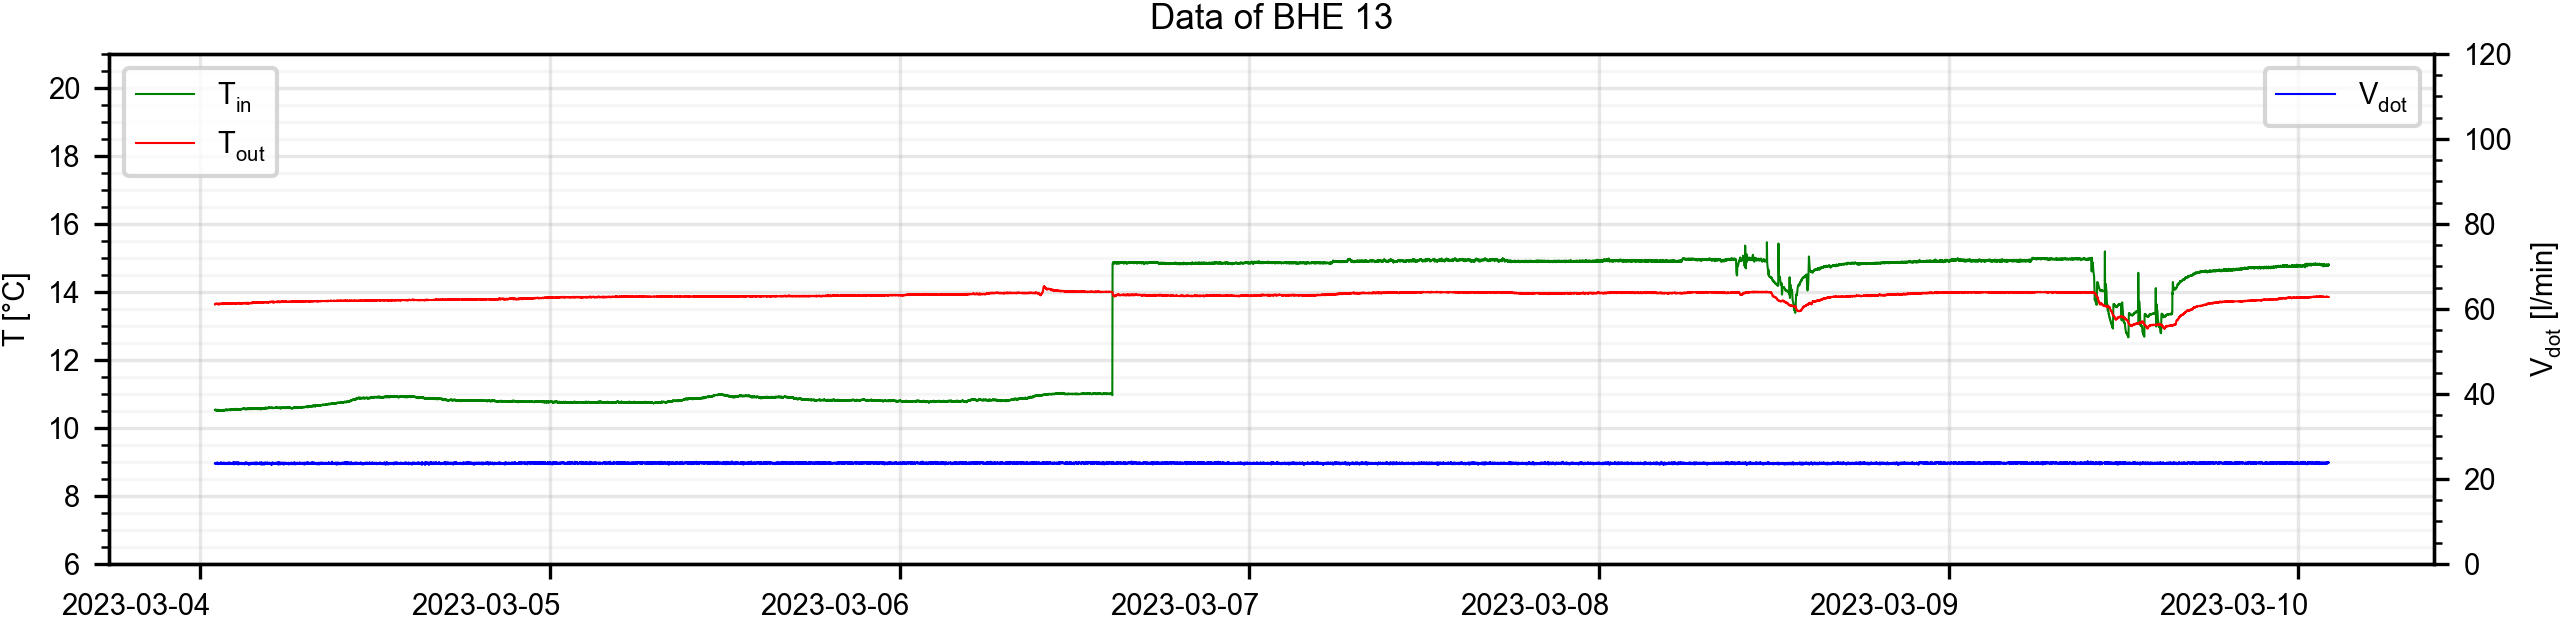

In [61]:
plot.plot_one_BHE(data, '13')

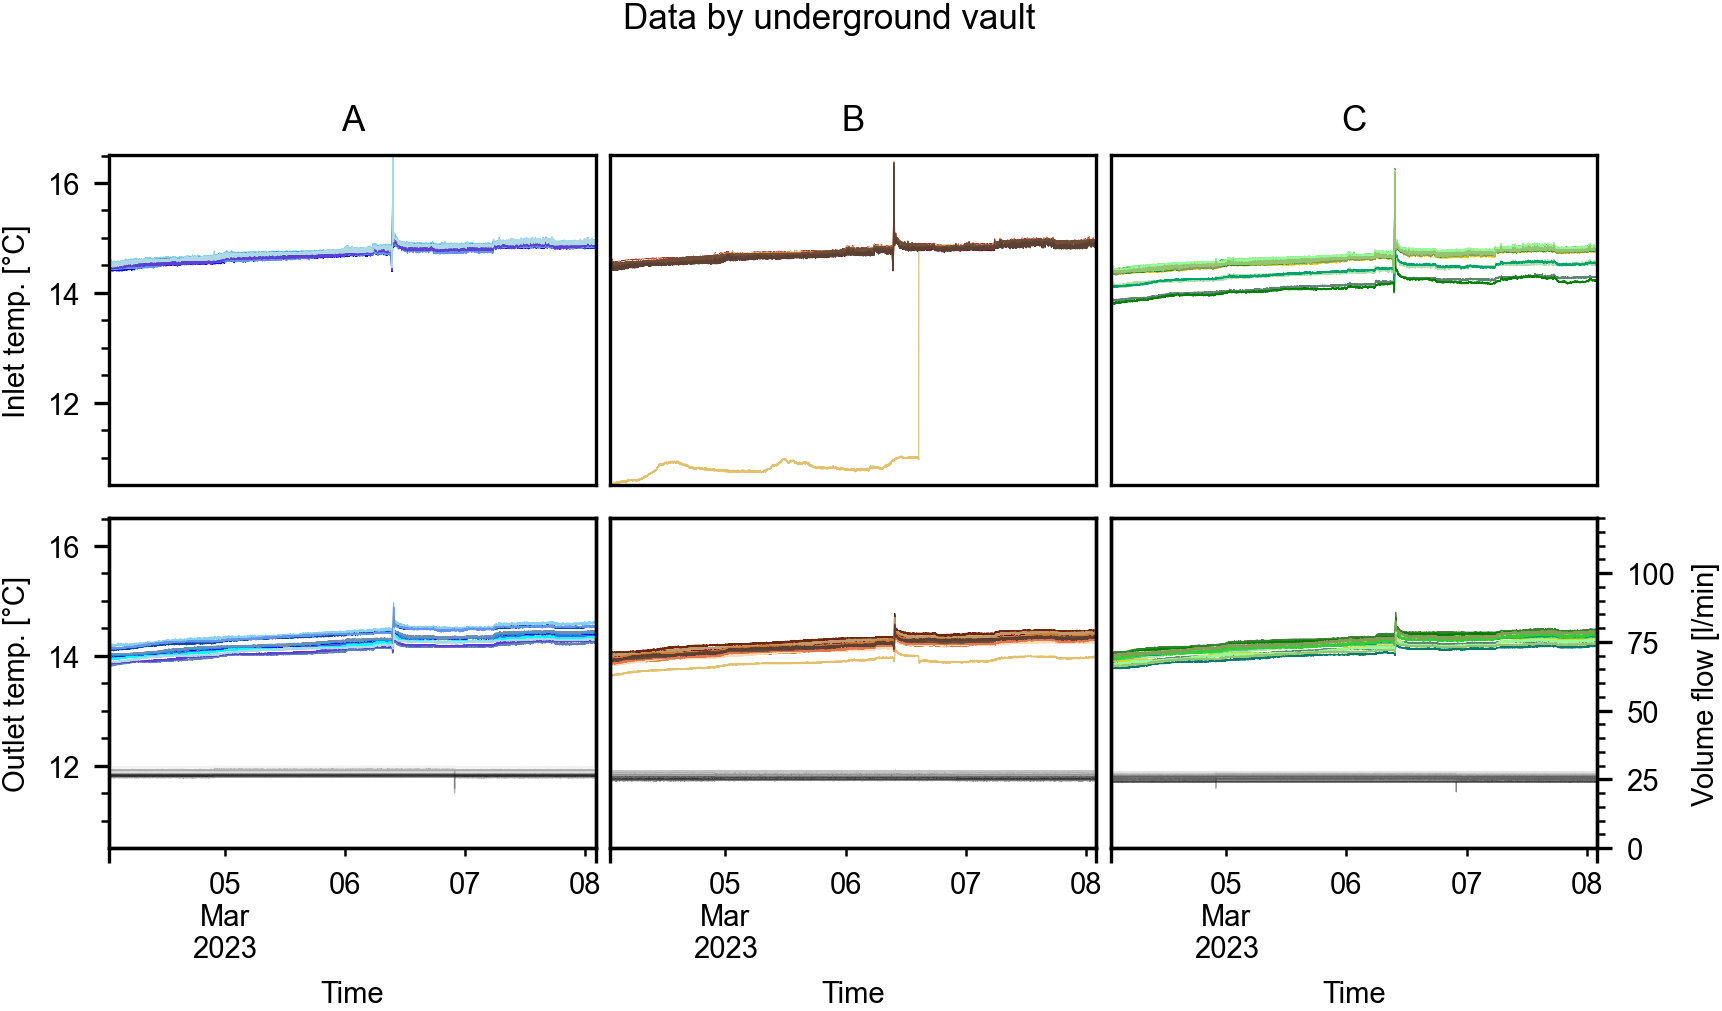

In [53]:
_=plot.plot_data_by_vault(data)

In [7]:
deltaT_df = analyse.get_deltaT_df(data)

In [8]:
deltaT_df.median(axis=0).loc['Probe_01_delta_T']#.values

-0.5299999999999994

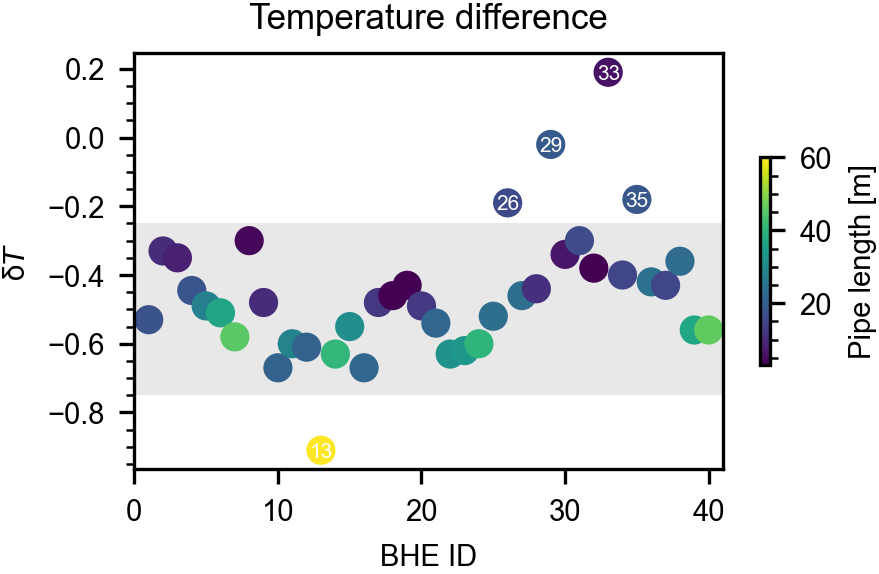

In [9]:
fig, ax = plt.subplots(1,1, figsize=(fig_width/2, 1.8), dpi=300)
median = deltaT_df.median(axis=0)
z = ax.scatter(np.arange(1,41,1), median.values, label='without correction', c=param_csv['Pipelength'].values)

for BHE in [13, 26, 29, 33, 35]: #np.arange(1,41,1):
    ax.annotate(f'{BHE:02d}', [BHE-0.8, median.loc[f'Probe_{BHE:02d}_delta_T']-0.02], color='white', size=5)
ax.set_title('Temperature difference')
ax.set_xlabel('BHE ID')
ax.set_ylabel('${\mathregular{\delta}T}$')
#ax.legend(bbox_to_anchor=(1.05,1))
ax.fill_between(np.arange(0,42,1), -.75, -0.25, color='lightgray', alpha=0.5, zorder=-10, edgecolor=None)
#fig.savefig('deltaT_correction.png', bbox_inches='tight')
#ax.legend()
ax.set_xlim(0,41)
plt.colorbar(z, label= 'Pipe length [m]', shrink=.5)
fig.savefig('deltaT.pdf', bbox_inches='tight')

In [10]:
statistics_data = pd.DataFrame()
statistics_data.index = data.index 
m = plot.ERC_Management()
west_in, south_in, east_in = m.generate_vault_id_strings(after='_T_in')
west_out, south_out, east_out = m.generate_vault_id_strings(after='_T_out')

statistics_data['west_in_T'] = data[west_in].mean(axis=1)
statistics_data['west_in_sd'] = data[west_in].std(axis=1)
statistics_data['south_in_T'] = data[south_in].mean(axis=1)
statistics_data['south_in_sd'] = data[south_in].std(axis=1)
statistics_data['east_in_T'] = data[east_in].mean(axis=1)
statistics_data['east_in_sd'] = data[east_in].std(axis=1)

statistics_data['west_out_T'] = data[west_out].mean(axis=1)
statistics_data['west_out_sd'] = data[west_out].std(axis=1)
statistics_data['south_out_T'] = data[south_out].mean(axis=1)
statistics_data['south_out_sd'] = data[south_out].std(axis=1)
statistics_data['east_out_T'] = data[east_out].mean(axis=1)
statistics_data['east_out_sd'] = data[east_out].std(axis=1)

In [11]:
west_in, south_in, east_in = analyse.get_ID_strings(after='_T_in', masked_BHEs = misfit_dict_in.keys())
west_out, south_out, east_out = analyse.get_ID_strings(after='_T_out', masked_BHEs = misfit_dict_out.keys())

statistics_data['west_in_T_f'] = data[west_in].mean(axis=1)
statistics_data['west_in_sd_f'] = data[west_in].std(axis=1)
statistics_data['south_in_T_f'] = data[south_in].mean(axis=1)
statistics_data['south_in_sd_f'] = data[south_in].std(axis=1)
statistics_data['east_in_T_f'] = data[east_in].mean(axis=1)
statistics_data['east_in_sd_f'] = data[east_in].std(axis=1)

statistics_data['west_out_T_f'] = data[west_out].mean(axis=1)
statistics_data['west_out_sd_f'] = data[west_out].std(axis=1)
statistics_data['south_out_T_f'] = data[south_out].mean(axis=1)
statistics_data['south_out_sd_f'] = data[south_out].std(axis=1)
statistics_data['east_out_T_f'] = data[east_out].mean(axis=1)
statistics_data['east_out_sd_f'] = data[east_out].std(axis=1)

stat = statistics_data.describe()

In [11]:
stat

,west_in_T,west_in_sd,south_in_T,south_in_sd,east_in_T,east_in_sd,west_out_T,west_out_sd,south_out_T,south_out_sd,...,south_in_T_f,south_in_sd_f,east_in_T_f,east_in_sd_f,west_out_T_f,west_out_sd_f,south_out_T_f,south_out_sd_f,east_out_T_f,east_out_sd_f
count,17411.000000,17411.000000,17411.000000,17411.000000,17411.000000,17411.000000,17411.000000,17411.000000,17411.000000,17411.000000,...,17411.000000,17411.000000,17411.000000,17411.000000,17411.000000,17411.000000,17411.000000,17411.000000,17411.000000,17411.000000
mean,14.698903,0.034754,14.574523,0.488880,14.508413,0.186416,14.233767,0.108600,14.163532,0.118337,...,14.711278,0.025780,14.604155,0.027756,14.233767,0.108600,14.191940,0.068374,14.192118,0.089392
std,0.319836,0.018783,0.365132,0.541416,0.304279,0.022415,0.211823,0.011863,0.201361,0.014454,...,0.315107,0.010249,0.312198,0.009699,0.211823,0.011863,0.203920,0.006006,0.201600,0.005719
min,12.589583,0.018647,12.645833,0.008876,12.538750,0.069462,13.127500,0.039312,13.131667,0.065799,...,12.644545,0.009045,12.565417,0.014994,13.127500,0.039312,13.145455,0.035496,13.172500,0.056151
25%,14.640833,0.030810,14.349167,0.022563,14.448125,0.182363,14.160833,0.107243,14.092500,0.105927,...,14.655455,0.022482,14.543333,0.023773,14.160833,0.107243,14.118182,0.066974,14.118125,0.087447
50%,14.764167,0.033575,14.621667,0.027784,14.572500,0.188648,14.280833,0.110823,14.207500,0.124350,...,14.780909,0.025406,14.667917,0.027303,14.280833,0.110823,14.238182,0.069177,14.238125,0.089998
75%,14.877500,0.036307,14.891667,1.116189,14.686250,0.193959,14.390000,0.113974,14.310833,0.130929,...,14.893636,0.028026,14.786667,0.030634,14.390000,0.113974,14.342727,0.071108,14.342187,0.092284
max,16.403333,0.580851,15.897500,1.558543,15.907500,0.684650,14.636667,0.239702,14.529167,0.226493,...,16.347273,0.440669,16.198333,0.492510,14.636667,0.239702,14.574545,0.182836,14.560000,0.172250


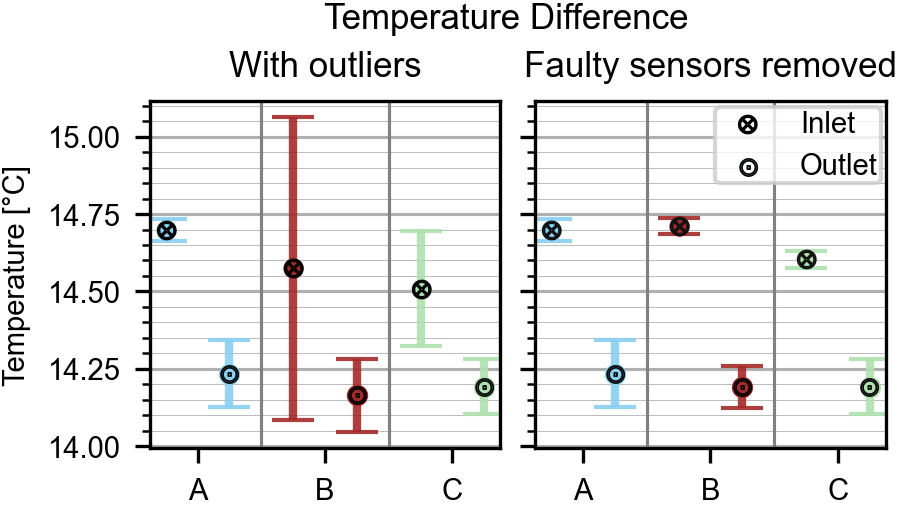

In [235]:
# Create a figure with two subplots, sharing the y-axis
fig, ax = plt.subplots(1, 2, figsize=(fig_width * 0.5, 1.5), dpi=300, sharey=True)
fig.suptitle('Temperature Difference', y=1.1)

# Define the x positions for inlet and outlet data points
x2 = [1, 3, 5]  # Outlets positions
x1 = [0, 2, 4]  # Inlet positions

inlet_marker = r'$\bigotimes$'  # Circle with an 'x' inside
outlet_marker = r'$\odot$'      # Circle with a dot inside

# Plot data for the first subplot (with outliers)
y_in = stat.loc['mean', ['west_in_T', 'south_in_T', 'east_in_T']].values
yerr_in = stat.loc['mean', ['west_in_sd', 'south_in_sd', 'east_in_sd']].values
y_out = stat.loc['mean', ['west_out_T', 'south_out_T', 'east_out_T']].values
yerr_out = stat.loc['mean', ['west_out_sd', 'south_out_sd', 'east_out_sd']].values

for i in range(len(y_in)):
    # Plot inlet data
    ax[0].errorbar(x1[i], y_in[i], yerr=yerr_in[i], linestyle=None, fmt='-', color='k', ecolor=colors[i], elinewidth=2, capsize=5, alpha=.9)
    ax[0].scatter(x1[i], y_in[i], facecolor=colors[i], edgecolor=None, zorder=100, s=20, marker='o', linewidth=.4)
    ax[0].scatter(x1[i], y_in[i], facecolor=colors[i], edgecolor='k', zorder=100, s=20, marker=inlet_marker, linewidth=.4, label='Inlet' if i == 0 else "")
    # Plot outlet data
    ax[0].errorbar(x2[i], y_out[i], yerr=yerr_out[i], linestyle=None, fmt='-', color='k', ecolor=colors[i], elinewidth=2, capsize=5, alpha=.9)
    ax[0].scatter(x2[i], y_out[i], facecolor=colors[i], edgecolor=None, zorder=100, s=17, marker='o', label="")
    ax[0].scatter(x2[i]-0.02, y_out[i], facecolor=colors[i], edgecolor='k', zorder=100, s=22, marker=outlet_marker, label='Outlet' if i == 0 else "", linewidth=.4)

# Plot data for the second subplot (faulty sensors removed)
y_in_f = stat.loc['mean', ['west_in_T_f', 'south_in_T_f', 'east_in_T_f']].values
yerr_in_f = stat.loc['mean', ['west_in_sd_f', 'south_in_sd_f', 'east_in_sd_f']].values
y_out_f = stat.loc['mean', ['west_out_T_f', 'south_out_T_f', 'east_out_T_f']].values
yerr_out_f = stat.loc['mean', ['west_out_sd_f', 'south_out_sd_f', 'east_out_sd_f']].values

for i in range(len(y_in_f)):
    # Plot inlet data
    ax[1].errorbar(x1[i], y_in_f[i], yerr=yerr_in_f[i], linestyle=None, fmt='-', color='k', ecolor=colors[i], elinewidth=2, capsize=5, alpha=.9)
    ax[1].scatter(x1[i], y_in_f[i], facecolor=colors[i], edgecolor=None, zorder=100, s=20, marker='o', linewidth=.4)
    ax[1].scatter(x1[i], y_in_f[i], facecolor=colors[i], edgecolor='#111111', zorder=100, s=20, marker=inlet_marker, linewidth=.4)
    # Plot outlet data
    ax[1].errorbar(x2[i], y_out_f[i], yerr=yerr_out_f[i], linestyle=None, fmt='-', color='k', ecolor=colors[i], elinewidth=2, capsize=5, alpha=.9)
    ax[1].scatter(x2[i], y_out_f[i], facecolor=colors[i], edgecolor=None, zorder=100, s=17, marker='o', label="")
    ax[1].scatter(x2[i]-0.02, y_out_f[i], facecolor=colors[i], edgecolor='k', zorder=100, s=22, marker=outlet_marker, label='Outlet' if i == 0 else "", linewidth=.4)

# Adding vertical lines after every two items
x_combined = [0, 1, 2, 3, 4, 5]
for i in range(1, len(x_combined) // 2):
    ax[0].axvline(x=x_combined[2 * i] - 0.5, color='gray', linewidth=.75)
    ax[1].axvline(x=x_combined[2 * i] - 0.5, color='gray', linewidth=.75)

# Setting x-ticks and labels for both subplots
for axi in ax:
    axi.set_xticks([(x_combined[i] + x_combined[i + 1]) / 2 for i in range(0, len(x_combined), 2)])
    axi.set_xticklabels(['A', 'B', 'C'])
    axi.grid(axis='y', which='minor', linewidth=.2)
    axi.grid(axis='y', which='major', linewidth=.75)

# Titles for subplots
ax[0].set_title('With outliers')
ax[1].set_title('Faulty sensors removed')

# Adjust the space between the subplots
fig.subplots_adjust(wspace=0.1)

# Adding the legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.91, 0.9), borderpad=0.1)
ax[0].set_ylabel('Temperature [°C]')

# Show plot (or save using plt.savefig)
fig.savefig('Mean_before_after.pdf', bbox_inches='tight')


In [12]:
BHE_colors = list(plot.ERC_Management().create_colordict().values())

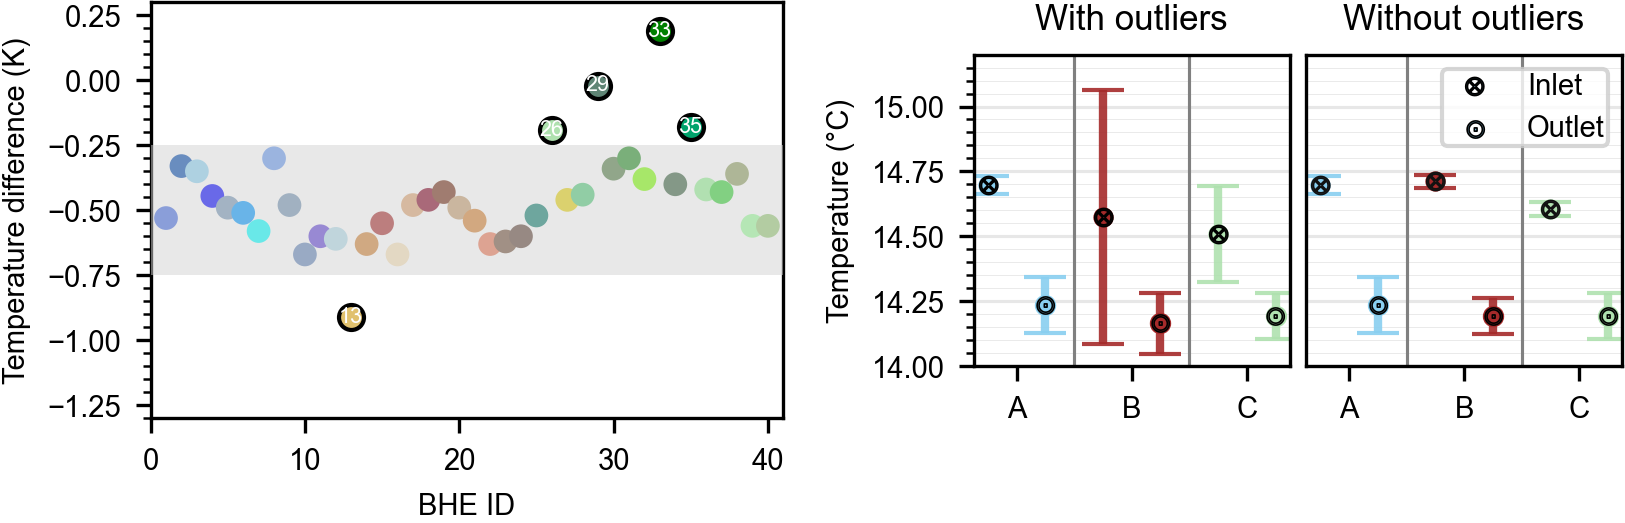

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming stat, colors, fig_width, deltaT_df, param_csv, etc., are already defined in the environment

# Create a figure with three subplots
#fig, ax = plt.subplots(1, 3, figsize=(fig_width, 1.8), dpi=300, width_ratios = [0.25,0.25,0.5])

import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(fig_width, 1.8), dpi=300)
# Define a GridSpec with 3 columns
gs = gridspec.GridSpec(8, 4, width_ratios=[2, 0.5, 1, 1])
gs.update(wspace=0.045, hspace=0.05) # set the spacing between axes.

# Create the subplots
ax = [0,0,0]
ax[0] = plt.subplot(gs[1:7, 2])  # First subplot in the first column
ax[1] = plt.subplot(gs[1:7, 3])  # Second subplot in the third column (skip second column for space)
ax[2] = plt.subplot(gs[:, 0])  # Third subplot in the fifth column (skip fourth column for more space)

# Plot 1: Temperature Difference (with outliers and faulty sensors removed)
# Define the x positions for inlet and outlet data points
x2 = [1, 3, 5]  # Outlets positions
x1 = [0, 2, 4]  # Inlet positions

inlet_marker = r'$\bigotimes$'  # Circle with an 'x' inside
outlet_marker = r'$\odot$'      # Circle with a dot inside

# Plot data for the first subplot (with outliers)
y_in = stat.loc['mean', ['west_in_T', 'south_in_T', 'east_in_T']].values
yerr_in = stat.loc['mean', ['west_in_sd', 'south_in_sd', 'east_in_sd']].values
y_out = stat.loc['mean', ['west_out_T', 'south_out_T', 'east_out_T']].values
yerr_out = stat.loc['mean', ['west_out_sd', 'south_out_sd', 'east_out_sd']].values

for i in range(len(y_in)):
    # Plot inlet data
    ax[0].errorbar(x1[i], y_in[i], yerr=yerr_in[i], linestyle=None, fmt='-', color='k', ecolor=colors[i], elinewidth=2, capsize=5, alpha=.9)
    ax[0].scatter(x1[i], y_in[i], facecolor=colors[i], edgecolor=None, zorder=100, s=20, marker='o', linewidth=.4)
    ax[0].scatter(x1[i], y_in[i], facecolor=colors[i], edgecolor='k', zorder=100, s=20, marker=inlet_marker, linewidth=.4, label='Inlet' if i == 0 else "")
    # Plot outlet data
    ax[0].errorbar(x2[i], y_out[i], yerr=yerr_out[i], linestyle=None, fmt='-', color='k', ecolor=colors[i], elinewidth=2, capsize=5, alpha=.9)
    ax[0].scatter(x2[i], y_out[i], facecolor=colors[i], edgecolor=None, zorder=100, s=17, marker='o', label="")
    ax[0].scatter(x2[i]-0.02, y_out[i], facecolor=colors[i], edgecolor='k', zorder=100, s=22, marker=outlet_marker, label='Outlet' if i == 0 else "", linewidth=.4)

# Plot data for the second subplot (faulty sensors removed)
y_in_f = stat.loc['mean', ['west_in_T_f', 'south_in_T_f', 'east_in_T_f']].values
yerr_in_f = stat.loc['mean', ['west_in_sd_f', 'south_in_sd_f', 'east_in_sd_f']].values
y_out_f = stat.loc['mean', ['west_out_T_f', 'south_out_T_f', 'east_out_T_f']].values
yerr_out_f = stat.loc['mean', ['west_out_sd_f', 'south_out_sd_f', 'east_out_sd_f']].values

for i in range(len(y_in_f)):
    # Plot inlet data
    ax[1].errorbar(x1[i], y_in_f[i], yerr=yerr_in_f[i], linestyle=None, fmt='-', color='k', ecolor=colors[i], elinewidth=2, capsize=5, alpha=.9)
    ax[1].scatter(x1[i], y_in_f[i], facecolor=colors[i], edgecolor=None, zorder=100, s=20, marker='o', linewidth=.4)
    ax[1].scatter(x1[i], y_in_f[i], facecolor=colors[i], edgecolor='#111111', zorder=100, s=20, marker=inlet_marker, linewidth=.4)
    # Plot outlet data
    ax[1].errorbar(x2[i], y_out_f[i], yerr=yerr_out_f[i], linestyle=None, fmt='-', color='k', ecolor=colors[i], elinewidth=2, capsize=5, alpha=.9)
    ax[1].scatter(x2[i], y_out_f[i], facecolor=colors[i], edgecolor=None, zorder=100, s=17, marker='o', label="")
    ax[1].scatter(x2[i]-0.02, y_out_f[i], facecolor=colors[i], edgecolor='k', zorder=100, s=22, marker=outlet_marker, label='Outlet' if i == 0 else "", linewidth=.4)

# Adding vertical lines after every two items
x_combined = [0, 1, 2, 3, 4, 5]
for i in range(1, len(x_combined) // 2):
    ax[0].axvline(x=x_combined[2 * i] - 0.5, color='gray', linewidth=.75)
    ax[1].axvline(x=x_combined[2 * i] - 0.5, color='gray', linewidth=.75)

# Setting x-ticks and labels for both subplots
for axi in ax[:2]:
    axi.set_xticks([(x_combined[i] + x_combined[i + 1]) / 2 for i in range(0, len(x_combined), 2)])
    axi.set_xticklabels(['A', 'B', 'C'])
    axi.grid(axis='y', which='minor', linewidth=.2, alpha=.3)
    axi.grid(axis='y', which='major', linewidth=.75, alpha=.3)

ax[1].set_yticklabels([])
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)
for tick in ax[1].yaxis.get_minor_ticks():
    tick.tick1line.set_visible(False)
    tick.tick2line.set_visible(False)


# Titles for subplots
ax[0].set_title('With outliers')
ax[1].set_title('Without outliers')
ax[0].set_ylabel('Temperature (°C)')

# Plot 2: Temperature Difference without correction
median = deltaT_df.median(axis=0)
z = ax[2].scatter(np.arange(1, 41, 1), median.values, label='without correction', c=BHE_colors, s=22)

for BHE in [13, 26, 29, 33, 35]:
    ax[2].annotate(f'{BHE:02d}', [BHE - 0.8, median.loc[f'Probe_{BHE:02d}_delta_T'] - 0.02], color='white', size=5.2)
    ax[2].scatter(BHE, median.values[BHE-1], edgecolors='k', c=BHE_colors[BHE-1])
#ax[2].set_title('Temperature differences')
ax[2].set_xlabel('BHE ID')
ax[2].set_ylabel('Temperature difference (K)')
ax[2].fill_between(np.arange(0, 42, 1), -.75, -0.25, color='lightgray', alpha=0.5, zorder=10, edgecolor=None)
ax[2].set_xlim(0, 41)
ax[2].set_ylim(-1.3,0.3)
#plt.colorbar(z, label='Pipe length [m]', shrink=.5, ax=ax[2])

# Adjust the space between the subplots
ax[0].set_ylim(14,15.2)
ax[1].set_ylim(14,15.2)

# Adding the legend
handles, labels = ax[0].get_legend_handles_labels()
ax[1].legend(handles, labels, loc='upper right', borderpad=0.1)

# Show plot (or save using plt.savefig)
fig.savefig('Combined_plot.pdf', bbox_inches='tight')
